# Notebook: inference with GLPN (Global-Local Path Networks) for monocular depth estimation

In this notebook, we are going to perform inference with [GLPN](https://arxiv.org/abs/2201.07436), which uses [SegFormer](https://huggingface.co/docs/transformers/master/en/model_doc/segformer)'s MiT-b4 (Mix Transformer) as encoder and a lightweight decoder for **monocular depth estimation** from a single image. The architecture (taken from the original paper) is shown below.

![architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/glpn_architecture.jpg)


## Set-up environment

First, we install HuggingFace Transformers and OpenCV (the latter is not required - it will only be useful for some fancy visualization).

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!pip install -q opencv-python

## Define model and feature extractor

Next, we instantiate a feature extractor (which can be used to prepare images for the model), and the pre-trained model itself with weights hosted on the hub.

In [ ]:
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation

feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

## Prepare image

Let's prepare an image for the model!

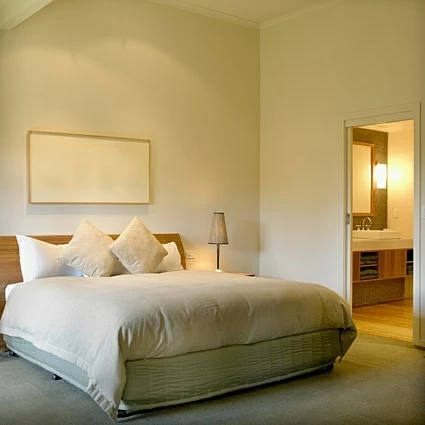

In [ ]:
from PIL import Image
import requests

url = 'https://images.all-free-download.com/images/graphicwebp/simple_room_picture_167607.webp'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 416, 416])


## Forward pass

In [ ]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)
  predicted_depth = outputs.predicted_depth

In [ ]:
predicted_depth.shape

torch.Size([1, 416, 416])

## Visualize

We can visualize the predicted depth in multiple ways. Here's the visualization using Matplotlib:

In [ ]:
# interpolate to original size
prediction = torch.nn.functional.interpolate(
                    predicted_depth.unsqueeze(1),
                    size=pixel_values.shape[-2:],
                    mode="bicubic",
                    align_corners=False,
             )
prediction = prediction.squeeze().cpu().numpy()

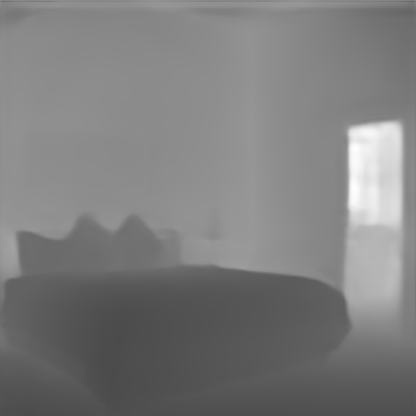

In [ ]:
import numpy as np
formatted = (prediction * 255 / np.max(prediction)).astype("uint8")
depth = Image.fromarray(formatted)
depth

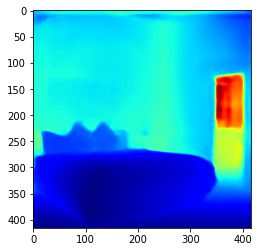

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(prediction, cmap="jet")